In [1]:
import pywt
import os
from pylab import *
from numpy import*
import pandas as pd

#### Обработка графиков ЭКГ и преобразование в таблицу

In [2]:
def get_ecg(key):
  way = 'train/' + key + '.npy'
  ecgsig = np.load(way).transpose().reshape((60000,))
  x = np.linspace(0,  1,  num = 2048)
  data = np.sin(250 * np.pi * x**2)
  coefs = pywt.downcoef('a', data, 'db20', mode='symmetric', level=1)
  st='sym5'
  coeffs = pywt.wavedec(ecgsig, st, level=5)
  row = coeffs[0]
  return row

In [3]:
def into_one_table(keys):
  row = get_ecg(keys[0])
  row = np.insert(row, 0, int(keys[0].strip('_hr')))
  table = [row]
  for i in range(target.index.start + 1, target.index.stop):
    row = get_ecg(keys[i])
    row = np.insert(row, 0, int(keys[i].strip('_hr')))
    table = np.vstack([table, row])
  table = pd.DataFrame(table)
  return table

In [4]:
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('train')[:-2])))
ECG_data = into_one_table(target)

In [5]:
ECG_data[0] = ECG_data[0].astype('int')
ECG_data = ECG_data.rename(columns={0: 'ecg_id'})

In [6]:
ECG_data = ECG_data.sort_values(by=['ecg_id'], ascending=True)

In [7]:
ECG_data

,ecg_id,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0.558936,0.551860,0.551007,0.561618,0.556675,0.645774,0.744957,0.649421,0.667106,0.731759
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,1.113606,1.088111,1.099680,1.132341,1.130250,1.788834,2.455783,1.818630,1.938019,2.363243
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,0.341701,0.340029,0.342162,0.341734,0.340499,0.346990,0.366654,0.343959,0.348800,0.365320
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,-0.267047,-0.258175,-0.261318,-0.274144,-0.273755,-0.519687,-0.765086,-0.532849,-0.575938,-0.730437
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,-0.304742,-0.297821,-0.302716,-0.310384,-0.311176,-0.513279,-0.714933,-0.521431,-0.558040,-0.686983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,0.005842,0.004748,0.005003,0.006885,0.006829,0.041791,0.079657,0.044349,0.050701,0.074361
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0.120157,0.117738,0.121368,0.121892,0.122540,0.189928,0.260724,0.190226,0.204078,0.251573
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,-0.128999,-0.124998,-0.127924,-0.131497,-0.131004,-0.222249,-0.318699,-0.224482,-0.242503,-0.305902
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,-0.159457,-0.155589,-0.158779,-0.161389,-0.160510,-0.233738,-0.313892,-0.233884,-0.249503,-0.303710


## N-граммы

In [8]:
import neurokit2
import sleepecg
import wfdb.processing
from nltk.util import ngrams

from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [9]:
def find_peaks(ecgsignal, peak):
    return wfdb.processing.correct_peaks(ecgsignal, rpeaks,
            search_radius=36, smooth_window_size=50, peak_dir=peak)

In [10]:
def get_cycle(ecgsignal, rpeaks): # разбиение ЭКГ на циклы
  ecgsignal_split = []
  cycle = []
  rpeaks = rpeaks[::-1]
  f = True #флаг конца массива с пиками
  f1 = True #флаг вхождения первого пика
  for i in range(len(ecgsignal)):
    if f and i == rpeaks[-1]:
      if f1:
        f1 = False
        cycle = []
      else:
        ecgsignal_split.append(cycle)
        cycle = []
      rpeaks = rpeaks[:-1]
      if f and len(rpeaks) == 0:
        f = False
    cycle.append(ecgsignal[i])
  return ecgsignal_split

In [11]:
def sign(x):
   return 1 if x > 0 else -1

In [12]:
def RTL(ecgsignal_split):
    sp = [[(i[0] - min(i[:10])), len(i), ((i[0] - min(i[:10]))/len(i))] for i in ecgsignal_split]
    s = []
    for i in range(len(sp) - 1):
        R = sp[i + 1][0] - sp[i][0]
        T = sp[i + 1][1] - sp[i][1]
        L = sp[i + 1][2] - sp[i][2]
        s.append([R, T, L])
    return s

In [13]:
def letters(data): # кодирование цикла по В.М. Успенскому 
  if data[0] == 1:
    if data[1] == -1:
      return 'C'
    else:
      if data[2] == -1:
        return 'E'
      return 'A'
  else:
    if data[1] == 1:
      return 'D'
    else:
      if data[2] == 1:
        return 'B'
      return 'F'

In [14]:
def encoding(ecgsignal_split):
    s = [[sign(i) for i in k] for k in RTL(ecgsignal_split)]
    stroka = ''
    for i in s:
        stroka += letters(i)
    return stroka

In [15]:
ECG_data_array = np.array(ECG_data)

In [74]:
R_Peaks = []

In [75]:
ecg_ids = []
encoding_ecgs = []

In [76]:
for ecgsignal in ECG_data_array:
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]
    
    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)
    
    rpeaks = find_peaks(ecgsignal, 'up')
    R_Peaks.append(rpeaks)
    
    ecgsignal_split = get_cycle(ecgsignal, rpeaks)
    encoding_ecg = encoding(ecgsignal_split)
    
    ecg_ids.append(ecg_id)
    encoding_ecgs.append(encoding_ecg)

In [26]:
encoding_ecg = pd.Series(encoding_ecgs, index=ecg_ids)

In [27]:
gts = pd.read_csv('train/train_gts.csv')
gts.record_name = gts.record_name.map(lambda x: float(x[:-3]))
gts = gts.sort_values(by='record_name')
gts.insert(2, 'encoding_ecg', array(encoding_ecg))
gts

,record_name,myocard,encoding_ecg
265,9.0,0,DDCADDCC
1407,34.0,0,DDDCCCFFFDDFCCCACFE
1833,43.0,0,BFABCFADDEC
441,52.0,0,DDEFBCCBCCF
1834,57.0,0,DDCADBCDD
...,...,...,...
1753,21784.0,0,DDCCFFAFAFFAFC
2008,21795.0,0,
72,21825.0,0,ECCDDDECB
2100,21831.0,0,DAFCCDDDCFCD


In [28]:
sick = gts[gts.myocard == 1].encoding_ecg
healthy = gts[gts.myocard == 0].encoding_ecg

In [29]:
sp_sick= []
for i in sick:
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 6))))
    for k in n:
        sp_sick.append(k)

In [30]:
sp_healthy= []
for i in healthy:
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 6))))
    for k in n:
        sp_healthy.append(k) 

In [31]:
def counter_and_sort(arr):
  quantity = {}
  for i in arr:
    if i in quantity:
      quantity[i] += 1
    else:
      quantity[i] = 1
  quantity = pd.Series(list(quantity.values()), index=list(quantity.keys())).sort_values(ascending=False)
  return quantity

In [32]:
q_sick = counter_and_sort(sp_sick)
q_health = counter_and_sort(sp_healthy)

In [33]:
only_sick = list(set(q_sick.index) - set(q_health.index))
only_health = list(set(q_health.index) - set(q_sick.index))

In [34]:
popular_sick = q_sick.iloc[:len(q_sick) // 2]
popular_health = q_health.iloc[:len(q_health) // 2]

In [35]:
popular_sick_only = list(set(popular_sick.index) - set(popular_health.index))
popular_health_only = list(set(popular_health.index) - set(popular_sick.index))

In [36]:
ngramms_ecgs = []
for ecg in array(gts):
    ngramms_ecg = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[2]), 6))))
    for k in n:
        ngramms_ecg.add(k)
    ngramms_ecgs.append(list(ngramms_ecg))

In [37]:
def func(ng):
    ng_health = sum(list(map(lambda x: 1 if x in only_health else 0, ng)))
    ng_sick = sum(list(map(lambda x: 1 if x in only_sick else 0, ng)))
    
    ng_popular_health = sum(list(map(lambda x: 1 if x in popular_health_only else 0, ng)))
    ng_popular_sick = sum(list(map(lambda x: 1 if x in popular_sick_only else 0, ng)))
    
    return [ng_health, ng_sick, ng_popular_health, ng_popular_sick]

In [38]:
arr = pd.DataFrame([func(ng) for ng in ngramms_ecgs])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(arr, gts.myocard, random_state=0, test_size=0.75)

In [40]:
cat = CatBoostClassifier(depth=9,  learning_rate=0.03)
cat.fit(X_train, y_train)

0:	learn: 0.6444023	total: 129ms	remaining: 2m 9s
1:	learn: 0.6138423	total: 132ms	remaining: 1m 6s
2:	learn: 0.5774073	total: 137ms	remaining: 45.4s
3:	learn: 0.5306864	total: 139ms	remaining: 34.6s
4:	learn: 0.4964606	total: 143ms	remaining: 28.4s
5:	learn: 0.4700599	total: 148ms	remaining: 24.4s
6:	learn: 0.4540542	total: 150ms	remaining: 21.2s
7:	learn: 0.4295647	total: 152ms	remaining: 18.9s
8:	learn: 0.4147643	total: 155ms	remaining: 17s
9:	learn: 0.3949265	total: 159ms	remaining: 15.7s
10:	learn: 0.3697582	total: 161ms	remaining: 14.4s
11:	learn: 0.3527951	total: 165ms	remaining: 13.6s
12:	learn: 0.3357232	total: 169ms	remaining: 12.8s
13:	learn: 0.3178687	total: 172ms	remaining: 12.1s
14:	learn: 0.3044209	total: 176ms	remaining: 11.5s
15:	learn: 0.2972470	total: 180ms	remaining: 11.1s
16:	learn: 0.2931901	total: 183ms	remaining: 10.6s
17:	learn: 0.2835730	total: 187ms	remaining: 10.2s
18:	learn: 0.2761427	total: 191ms	remaining: 9.85s
19:	learn: 0.2699636	total: 194ms	remaining

199:	learn: 0.1652362	total: 711ms	remaining: 2.84s
200:	learn: 0.1651855	total: 715ms	remaining: 2.84s
201:	learn: 0.1651755	total: 718ms	remaining: 2.84s
202:	learn: 0.1651116	total: 721ms	remaining: 2.83s
203:	learn: 0.1651068	total: 724ms	remaining: 2.83s
204:	learn: 0.1650917	total: 726ms	remaining: 2.82s
205:	learn: 0.1650161	total: 730ms	remaining: 2.81s
206:	learn: 0.1649998	total: 731ms	remaining: 2.8s
207:	learn: 0.1649927	total: 734ms	remaining: 2.79s
208:	learn: 0.1649764	total: 736ms	remaining: 2.79s
209:	learn: 0.1649487	total: 739ms	remaining: 2.78s
210:	learn: 0.1649435	total: 741ms	remaining: 2.77s
211:	learn: 0.1649267	total: 744ms	remaining: 2.77s
212:	learn: 0.1648485	total: 746ms	remaining: 2.76s
213:	learn: 0.1648175	total: 749ms	remaining: 2.75s
214:	learn: 0.1647431	total: 752ms	remaining: 2.75s
215:	learn: 0.1647406	total: 754ms	remaining: 2.74s
216:	learn: 0.1647181	total: 756ms	remaining: 2.73s
217:	learn: 0.1646940	total: 760ms	remaining: 2.73s
218:	learn: 0

383:	learn: 0.1608454	total: 1.71s	remaining: 2.73s
384:	learn: 0.1608375	total: 1.71s	remaining: 2.73s
385:	learn: 0.1608301	total: 1.72s	remaining: 2.73s
386:	learn: 0.1608237	total: 1.72s	remaining: 2.73s
387:	learn: 0.1608160	total: 1.73s	remaining: 2.73s
388:	learn: 0.1608075	total: 1.74s	remaining: 2.73s
389:	learn: 0.1607996	total: 1.74s	remaining: 2.73s
390:	learn: 0.1607934	total: 1.75s	remaining: 2.73s
391:	learn: 0.1607856	total: 1.76s	remaining: 2.72s
392:	learn: 0.1607783	total: 1.76s	remaining: 2.72s
393:	learn: 0.1607706	total: 1.77s	remaining: 2.72s
394:	learn: 0.1607652	total: 1.78s	remaining: 2.72s
395:	learn: 0.1607573	total: 1.78s	remaining: 2.72s
396:	learn: 0.1607501	total: 1.79s	remaining: 2.72s
397:	learn: 0.1607437	total: 1.79s	remaining: 2.72s
398:	learn: 0.1607376	total: 1.8s	remaining: 2.71s
399:	learn: 0.1607308	total: 1.81s	remaining: 2.71s
400:	learn: 0.1607242	total: 1.81s	remaining: 2.71s
401:	learn: 0.1607189	total: 1.82s	remaining: 2.71s
402:	learn: 0

568:	learn: 0.1601088	total: 2.9s	remaining: 2.2s
569:	learn: 0.1601063	total: 2.91s	remaining: 2.19s
570:	learn: 0.1601043	total: 2.91s	remaining: 2.19s
571:	learn: 0.1601024	total: 2.92s	remaining: 2.18s
572:	learn: 0.1601004	total: 2.92s	remaining: 2.18s
573:	learn: 0.1600985	total: 2.93s	remaining: 2.18s
574:	learn: 0.1600964	total: 2.94s	remaining: 2.17s
575:	learn: 0.1600942	total: 2.95s	remaining: 2.17s
576:	learn: 0.1600923	total: 2.95s	remaining: 2.16s
577:	learn: 0.1600905	total: 2.96s	remaining: 2.16s
578:	learn: 0.1600887	total: 2.96s	remaining: 2.16s
579:	learn: 0.1600867	total: 2.97s	remaining: 2.15s
580:	learn: 0.1600847	total: 2.98s	remaining: 2.15s
581:	learn: 0.1600826	total: 2.98s	remaining: 2.14s
582:	learn: 0.1600808	total: 2.99s	remaining: 2.14s
583:	learn: 0.1600789	total: 3s	remaining: 2.13s
584:	learn: 0.1600768	total: 3s	remaining: 2.13s
585:	learn: 0.1600745	total: 3.01s	remaining: 2.13s
586:	learn: 0.1600725	total: 3.02s	remaining: 2.12s
587:	learn: 0.160070

727:	learn: 0.1598718	total: 3.9s	remaining: 1.46s
728:	learn: 0.1598708	total: 3.91s	remaining: 1.45s
729:	learn: 0.1598699	total: 3.92s	remaining: 1.45s
730:	learn: 0.1598687	total: 3.92s	remaining: 1.44s
731:	learn: 0.1598674	total: 3.93s	remaining: 1.44s
732:	learn: 0.1598665	total: 3.93s	remaining: 1.43s
733:	learn: 0.1598653	total: 3.94s	remaining: 1.43s
734:	learn: 0.1598643	total: 3.94s	remaining: 1.42s
735:	learn: 0.1598630	total: 3.95s	remaining: 1.42s
736:	learn: 0.1598619	total: 3.96s	remaining: 1.41s
737:	learn: 0.1598607	total: 3.96s	remaining: 1.41s
738:	learn: 0.1598596	total: 3.97s	remaining: 1.4s
739:	learn: 0.1598587	total: 3.98s	remaining: 1.4s
740:	learn: 0.1598575	total: 3.98s	remaining: 1.39s
741:	learn: 0.1598565	total: 3.99s	remaining: 1.39s
742:	learn: 0.1598555	total: 3.99s	remaining: 1.38s
743:	learn: 0.1598545	total: 4s	remaining: 1.38s
744:	learn: 0.1598534	total: 4s	remaining: 1.37s
745:	learn: 0.1598525	total: 4.01s	remaining: 1.36s
746:	learn: 0.1598516

897:	learn: 0.1597274	total: 4.92s	remaining: 558ms
898:	learn: 0.1597269	total: 4.92s	remaining: 553ms
899:	learn: 0.1597262	total: 4.93s	remaining: 547ms
900:	learn: 0.1597255	total: 4.93s	remaining: 542ms
901:	learn: 0.1597250	total: 4.94s	remaining: 536ms
902:	learn: 0.1597242	total: 4.94s	remaining: 531ms
903:	learn: 0.1597237	total: 4.95s	remaining: 526ms
904:	learn: 0.1597230	total: 4.96s	remaining: 520ms
905:	learn: 0.1597224	total: 4.96s	remaining: 515ms
906:	learn: 0.1597218	total: 4.97s	remaining: 509ms
907:	learn: 0.1597212	total: 4.97s	remaining: 504ms
908:	learn: 0.1597205	total: 4.98s	remaining: 499ms
909:	learn: 0.1597200	total: 4.99s	remaining: 493ms
910:	learn: 0.1597195	total: 4.99s	remaining: 488ms
911:	learn: 0.1597187	total: 5s	remaining: 483ms
912:	learn: 0.1597181	total: 5.01s	remaining: 477ms
913:	learn: 0.1597175	total: 5.01s	remaining: 472ms
914:	learn: 0.1597166	total: 5.02s	remaining: 466ms
915:	learn: 0.1597158	total: 5.03s	remaining: 461ms
916:	learn: 0.1

In [41]:
f1_score(y_test, cat.predict(X_test), average='macro')

0.8612836391384646

In [42]:
f1_score(y_train, cat.predict(X_train), average='macro')

0.8722361284939507

## Heart Rate Variability

In [93]:
import matplotlib.pyplot as plt

In [78]:
RR = list(map(lambda rpeaks: 60 / (np.diff(rpeaks) + 0.00001), R_Peaks))

In [79]:
M = list(map(lambda rr: rr.mean(), RR))

In [80]:
len(M)

2101

(array([4.266e+03, 2.470e+02, 7.000e+01, 6.600e+01, 4.100e+01, 4.900e+01,
        2.700e+01, 4.100e+01, 2.700e+01, 4.000e+00]),
 array([2.28169739e-01, 3.63636593e+05, 7.27272959e+05, 1.09090932e+06,
        1.45454569e+06, 1.81818205e+06, 2.18181842e+06, 2.54545478e+06,
        2.90909115e+06, 3.27272752e+06, 3.63636388e+06]),
 <BarContainer object of 10 artists>)

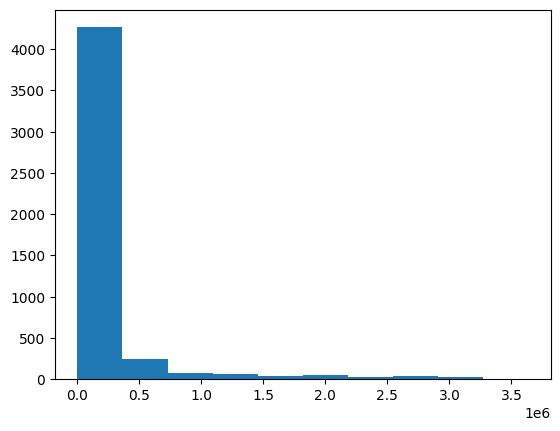

In [56]:
plt.hist(M)

In [90]:
def analysis_mat_expectation(M):
    
    if M < 0.5:
        conclusion = 0
    elif 0.5 <= M < 0.66:
        conclusion = 1
    elif 0.66 <= M:
        conclusion = 2
    return conclusion

In [91]:
conclusions = list(map(lambda m: analysis_mat_expectation(m), M))